In [23]:
import sys
sys.path.append('../')
from utility import stan_utility
import pystan

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

### 1. Gamma Distribution

This distribution is given by the following equation, where $\Gamma(\alpha)$ is the gamma function, that is, for all positive numbers $\Gamma(\alpha) = (\alpha-1)!$.

$$x^{\alpha-1}\frac {e^{-x/\theta}}{\theta^{\alpha}\Gamma(\alpha)}\quad for\ x > 0\quad \alpha,\theta > 0$$

$\alpha$ - shape coefficient

$\theta$ - scale coefficient

In [24]:
# Construct a few example distributions.
alpha = [1.0,3.0,3.0,5.0]
theta = [1.0,1.0,3.0,4.0]
gammas = pd.DataFrame({"shape={},scale={}".format(str(alpha[i]),str(theta[i])):np.random.gamma(alpha[i],theta[i],size=10000) for i in range(4)})
gammas.head()

,"shape=1.0,scale=1.0","shape=3.0,scale=1.0","shape=3.0,scale=3.0","shape=5.0,scale=4.0"
0,1.106552,1.617566,6.189758,25.100306
1,0.623748,3.992327,2.834128,17.140791
2,0.559259,5.641699,21.183171,28.265709
3,2.216794,1.500178,12.077762,20.285912
4,0.479286,1.958798,11.778527,10.457261


In [25]:
# Melt for better histogram cooperation
gammas_melted = gammas.melt()
gammas_melted.head()

,variable,value
0,"shape=1.0,scale=1.0",1.106552
1,"shape=1.0,scale=1.0",0.623748
2,"shape=1.0,scale=1.0",0.559259
3,"shape=1.0,scale=1.0",2.216794
4,"shape=1.0,scale=1.0",0.479286


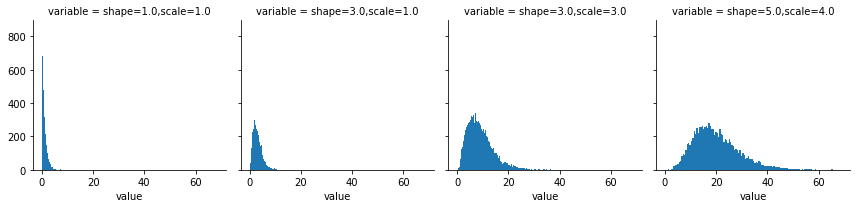

In [26]:
# Plot histograms
grid = sns.FacetGrid(gammas_melted, col='variable',sharex=True)
grid.map(plt.hist,'value',cumulative=False,bins=128)

Gamma distribution is typically used for prediction of wait time until future events. While the exponential distribution predicts time until first event, gamma distr predicts wait time until k-th event. In this exercise we find parameters for this distribution so that "we wait between 5 to 10 units of time" with 98% probability.
Increasing alpha changes the skewness of the distribution (by 2/$\sqrt{\alpha}$ to be more precise). Increasing scale (theta) splits the variables further across the axis.

We will now find the parameters using albebra solver in stan.

In [29]:
gamma_model = stan_utility.compile_model('gamma_tune.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b36463ffcb37e7800c2aba9d5826c89 NOW.


In [55]:
params = {'y_guess':np.array([3,1]),'tq':np.array([5,1])}
sample = gamma_model.sampling(data=params, seed=1206, algorithm='Fixed_param')
print(sample)

Inference for Stan model: anon_model_9b36463ffcb37e7800c2aba9d5826c89.
4 chains, each with iter=2000; warmup=0; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   8.92     0.0    0.0   8.92   8.92   8.92   8.92   8.92      2   1.02
theta   3.46 6.3e-168.9e-16   3.46   3.46   3.46   3.46   3.46      2    1.0
lp__     0.0     nan    0.0    0.0    0.0    0.0    0.0    0.0    nan    nan

Samples were drawn using Fixed_param at Fri Jun 12 20:27:33 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


(array([2.570e+02, 1.925e+03, 3.234e+03, 2.591e+03, 1.298e+03, 4.940e+02,
        1.510e+02, 3.500e+01, 1.200e+01, 3.000e+00]),
 array([ 6.10479468, 14.32180646, 22.53881824, 30.75583003, 38.97284181,
        47.18985359, 55.40686537, 63.62387715, 71.84088894, 80.05790072,
        88.2749125 ]),
 <a list of 10 Patch objects>)

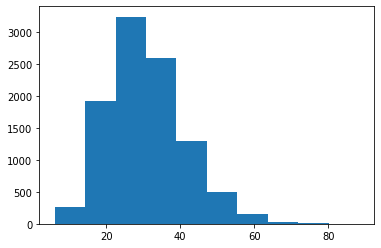

In [54]:
solution = np.random.gamma(8.92,3.46,size=10000)
plt.hist(solution)

wtf is this

### 2. Negative Binomial Distribution

This is a distribution that models the number of failures in a sequence of independent and identically distributed Bernoulli trials before a specified (non-random) number of successes (denoted as r) occurs.
$$\binom{k+r-1}{k}p^r(1-p)^k$$

In [66]:
r = [5,5,20,20]
p = [0.1,0.5,0.1,0.5]
nbinom = pd.DataFrame({"r={},p={}".format(str(n[i]),str(p[i])):np.random.negative_binomial(r[i],p[i],size=10000) for i in range(4)})
nbinom.head()

,"r=5,p=0.1","r=5,p=0.5","r=20,p=0.1","r=20,p=0.5"
0,10,8,206,15
1,68,4,114,20
2,18,4,133,10
3,52,14,203,23
4,46,3,106,15


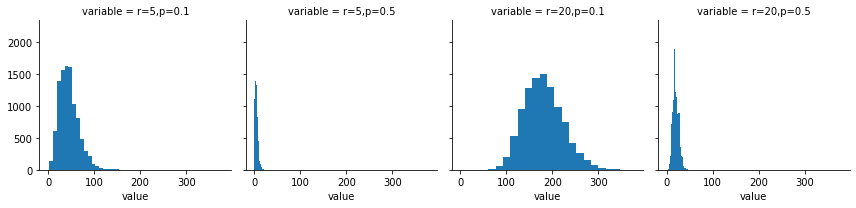

In [67]:
nbinom_melt = nbinom.melt()
grid = sns.FacetGrid(nbinom_melt, col='variable', sharex=True)
grid.map(plt.hist, 'value', cumulative=False, bins=20)

It can be seen that for any set of experiments, lower probability of success leads to a much higher number of failures before a specified number of successes appears. The average number of successes per experiment is equal to $\frac{pr}{1-p}$

Now we add Poisson distribution to it, so we can compare those two.
Its probability mass function is defined as $$\frac{\lambda^k e^{-\lambda}}{k!}$$

It is typical for situation where we want to obtain the proability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event. This typically means rare events.

In [69]:
# Instantiate nbinom and poisson distribution set with the same base parameters for comparison
p = [0.2,0.4,0.6,0.8]
mi = [stats.nbinom.mean(100, x) for x in p]
nbinom = pd.DataFrame({"r=100,p={}".format(p[i]):np.random.negative_binomial(100,p[i],size=10000) for i in range(4)})
poisson = pd.DataFrame({"mi={}".format(mi[i]):np.random.poisson(mi[i], size=10000) for i in range(4)})
print(nbinom.head())
print(poisson.head())

   r=100,p=0.2  r=100,p=0.4  r=100,p=0.6  r=100,p=0.8
0          484          147           63           24
1          474          170           66           14
2          462          119           51           17
3          361          116           67           23
4          492          143           48           27
   mi=400.0  mi=150.0  mi=66.66666666666667  mi=25.0
0       420       149                    73       21
1       387       152                    81       27
2       410       134                    71       28
3       413       155                    71       30
4       431       140                    80       22


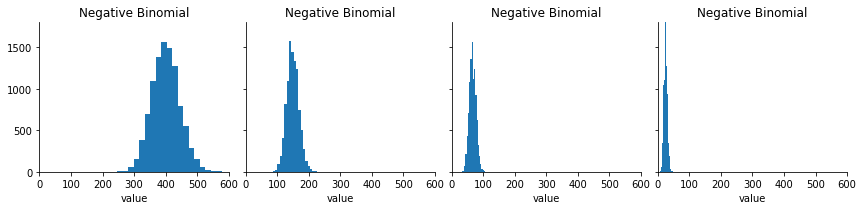

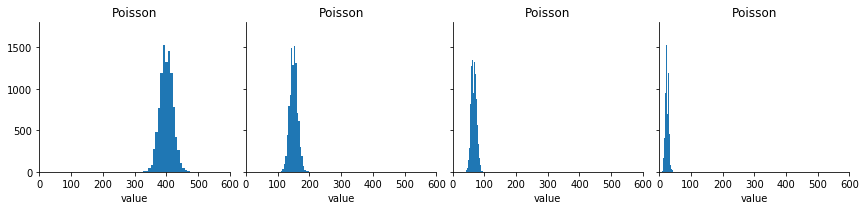

In [73]:
# Melt and prepare for histogram creation
nbinom_melt = nbinom.melt()
poisson_melt = poisson.melt()

grid = sns.FacetGrid(nbinom_melt, col='variable',sharex=True)
grid.map(plt.hist, "value", cumulative=False, bins=20)
grid.set(title='Negative Binomial',xlim=(0, 600), ylim=(0, 1800))

grid = sns.FacetGrid(poisson_melt, col='variable',sharex=True)
grid.set(title='Poisson')
grid.map(plt.hist, "value", cumulative=False, bins=20)
grid.set(title='Poisson',xlim=(0, 600), ylim=(0, 1800))

- Nbinom dists are wider in general, which means they have higher standard deviation than poisson dists with the same mean.
- Poisson dist is defined by amount of successes expected with unknown number of trials.
- Nbinom dist is defined by probability of amount of failures. With an increase in success rate (in single trial, p), expected amount of failures decreases.

### 3. Student-t distribution

This is a distribution which can be a generalization fo Gaussian distributions with varying scale. I won't write the pmf here as it's too complicated, just google it. In this exercise we'll change degrees of freedom and dispersion parameterizations to see how changing them moves from normal distribution. We will also take a special case of degrees of freedom equal to 1 which represents Cauchy distribution. We'll observe mean and variance changes while increasing number of samples.

In [80]:
n=[1,2,3,5,10,15,25,42]
student = pd.DataFrame({'T-student_v={}'.format(param):np.random.standard_t(param, size=10000) for param in n})
student.head()

,T-student_v=1,T-student_v=2,T-student_v=3,T-student_v=5,T-student_v=10,T-student_v=15,T-student_v=25,T-student_v=42
0,-0.668213,2.505014,2.736598,4.370120,-1.048915,1.507162,-1.376040,-1.119051
1,-2.899333,0.225767,-1.087662,-0.649585,-0.870937,0.420157,1.028629,-0.045464
2,0.567237,-0.151260,-2.269437,-1.843642,-0.522682,1.592070,0.380490,0.910464
3,-0.101349,0.322179,0.134459,1.254091,0.504560,-2.004004,0.390866,-0.389656
4,0.702686,1.218435,-0.730218,0.169385,-0.084469,-0.000390,1.306155,-1.835579


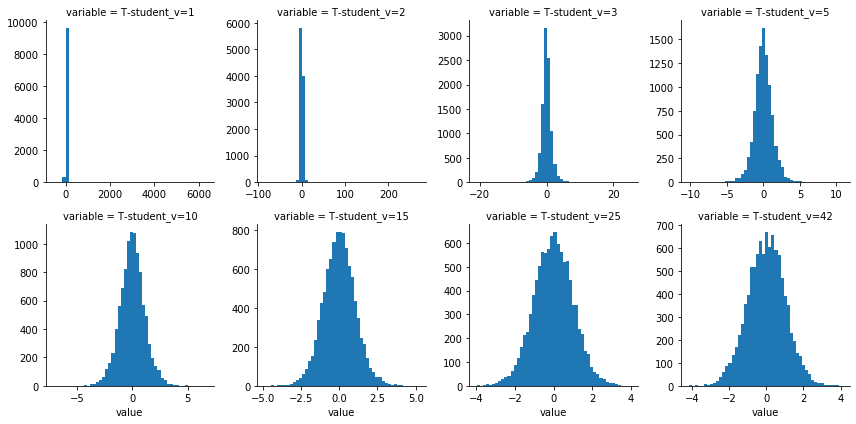

In [81]:
student_melt = student.melt()
grid = sns.FacetGrid(student_melt, col="variable", sharey=False, sharex=False, col_wrap=4)
grid.map(plt.hist, "value", cumulative=False, bins=50)

In [84]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

#Predefining some colors for the conveninece of using them in plots.

colors=[light, light_highlight, mid, mid_highlight,
        dark, dark_highlight, green, blue, red, light_grey]

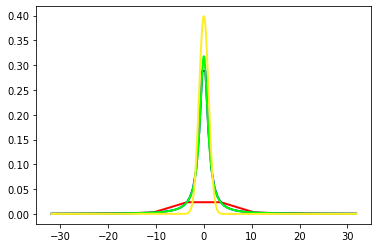

In [90]:
# Cauchy distribution
samples = [10, 100, 1000]
fig, ax = plt.subplots(1, 1)
for i in range(len(samples)):
    xc = np.linspace(stats.t.ppf(0.01, n[0]),
                    stats.t.ppf(0.99, n[0]),samples[i])
    ax.plot(xc, stats.t.pdf(xc, n[0]),color=colors[8-i],linewidth=2)

ax.plot(xc, stats.norm.pdf(xc),color=colors[2],linewidth=2)
plt.show()

In [92]:
student_model = stan_utility.compile_model('3_student_t_family.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b32ece66150ba9ec66a763deb964f72f NOW.


For its: 10
 Summary: Inference for Stan model: anon_model_b32ece66150ba9ec66a763deb964f72f.
1 chains, each with iter=10; warmup=5; thin=1; 
post-warmup draws per chain=5, total post-warmup draws=5.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      1.31    0.68   1.54  -0.25   0.04   0.77   2.84    3.2      5   0.74
lp__  -1.02    0.46   1.16  -2.42   -2.2  -0.46  -0.05  -0.03      6   0.73

Samples were drawn using NUTS at Fri Jun 12 21:52:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
For its: 100
 Summary: Inference for Stan model: anon_model_b32ece66150ba9ec66a763deb964f72f.
1 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=50.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      -0.1    0.36    1.2  -2.09  -0.98  -0.08   0.52   2.42     11

For its: 1000
 Summary: Inference for Stan model: anon_model_b32ece66150ba9ec66a763deb964f72f.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.59    0.58   7.54  -13.5  -0.99   0.12   1.39  19.96    168    1.0
lp__  -1.64    0.26   1.83  -6.29  -2.69  -0.85   -0.2-3.3e-3     49   1.02

Samples were drawn using NUTS at Fri Jun 12 21:52:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
For its: 10000
 Summary: Inference for Stan model: anon_model_b32ece66150ba9ec66a763deb964f72f.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.02     0.3   9.18 -11.44  -0.99   0.04 

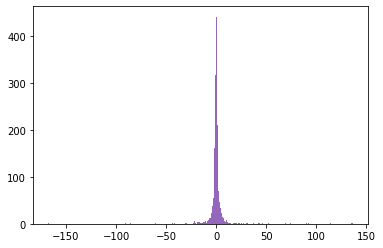

In [93]:
iterations = [10,100,1000,10000]
for its in iterations:
    model=student_model.sampling(data={'n': 1.0,
                           'mu': 0.0,
                           'sigma': 1.0},
                     iter=its,
                     chains=1,
                     seed=42)
    dist = model.extract()
    THist = plt.hist(dist['y'], bins=its)
    print('For its: {its}\n Summary: {stansum}'.format(its=its,
                                                         stansum=model.stansummary()))
    
THist = plt.hist(dist['y'], bins=1000)

Inference for Stan model: anon_model_b32ece66150ba9ec66a763deb964f72f.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      0.07    0.19   1.94  -3.68  -0.62   0.05   0.65    4.4    100   1.01
lp__  -0.75     0.1   0.95  -3.26  -0.93  -0.34   -0.1-1.4e-3     88    1.0

Samples were drawn using NUTS at Fri Jun 12 21:54:14 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


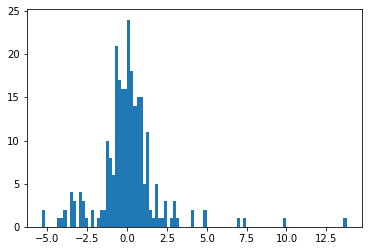

In [95]:
model=student_model.sampling(data={'n': 1.0,
                       'mu': 0.0,
                       'sigma': 1.0},
                     iter=500,
                     chains=1,
                     seed=42)
dist = model.extract()
THist = plt.hist(dist['y'], bins=100)
print(model.stansummary())

Increasing sampling number causes the mean to approach zero and variance to grow.

### 4. Multivariate normal distribution
